In [1]:
import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sys import stdout
from openpyxl import Workbook


w1 = r'./Well_Logging/SNRG-0001_basic_logs.las'
w2 = r'./Well_Logging/SNRG-0002_basic_logs.las'
w3 = r'./Well_Logging/SNRG-0003_basic_logs.las'
w4 = r'./Well_Logging/SNRG-0004_basic_logs.las'


In [2]:
las_1 = lasio.read(w1)
las_1.to_csv(stdout)


DEPTH,AO10,AO20,AORX,AT10,AT20,DEPTH,GR,HDRA,NPHI,PEFZ,RHOZ,TNPH
FT,OHMM,OHMM,OHMM,OHMM,OHMM,FT,GAPI,G/C3,dec,B/E,G/C3,dec
0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7.5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

In [3]:
df = las_1.df()
df

,AO10,AO20,AORX,AT10,AT20,DEPTH:2,GR,HDRA,NPHI,PEFZ,RHOZ,TNPH
DEPTH:1,,,,,,,,,,,,
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8998.0,NaN,NaN,NaN,NaN,NaN,8998.0,NaN,NaN,NaN,NaN,NaN,NaN
8998.5,NaN,NaN,NaN,NaN,NaN,8998.5,NaN,NaN,NaN,NaN,NaN,NaN
8999.0,NaN,NaN,NaN,NaN,NaN,8999.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.reset_index(inplace =True)
df

,DEPTH:1,AO10,AO20,AORX,AT10,AT20,DEPTH:2,GR,HDRA,NPHI,PEFZ,RHOZ,TNPH
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,8998.0,NaN,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,8998.5,NaN,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,8999.0,NaN,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,8999.5,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
GR_max = df['GR'].max()
GR_min = df['GR'].min()

In [6]:
print(GR_max," ",GR_min)

202.263   8.304


In [7]:
df.describe()

,DEPTH:1,AO10,AO20,AORX,AT10,AT20,DEPTH:2,GR,HDRA,NPHI,PEFZ,RHOZ,TNPH
count,18001.000000,8220.000000,8220.000000,8220.000000,8220.000000,8220.000000,8401.00000,8116.000000,8159.000000,8140.000000,8158.000000,8159.000000,8140.000000
mean,4500.000000,6278.283751,6278.283751,6278.283751,6278.283751,6278.283751,6900.00000,73.712321,0.091406,0.093679,3.655489,2.653141,0.093679
std,2598.292717,21748.160774,21748.160774,21748.160774,21748.160774,21748.160774,1212.65207,46.026915,0.071117,0.067164,0.602250,0.121233,0.067164
min,0.000000,3.540000,3.540000,3.540000,3.540000,3.540000,4800.00000,8.304000,-0.072000,-0.000300,2.091000,1.659000,-0.000300
25%,2250.000000,49.984750,49.984750,49.984750,49.984750,49.984750,5850.00000,27.804750,0.040000,0.032200,3.214000,2.596000,0.032200
50%,4500.000000,166.342500,166.342500,166.342500,166.342500,166.342500,6900.00000,64.811500,0.057000,0.073600,3.580000,2.673000,0.073600
75%,6750.000000,762.695750,762.695750,762.695750,762.695750,762.695750,7950.00000,120.141500,0.124000,0.156600,4.014000,2.723000,0.156600
max,9000.000000,108302.007800,108302.007800,108302.007800,108302.007800,108302.007800,9000.00000,202.263000,0.348000,0.303300,5.384000,2.907000,0.303300


In [8]:
df.dtypes

DEPTH:1    float64
AO10       float64
AO20       float64
AORX       float64
AT10       float64
AT20       float64
DEPTH:2    float64
GR         float64
HDRA       float64
NPHI       float64
PEFZ       float64
RHOZ       float64
TNPH       float64
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18001 entries, 0 to 18000
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEPTH:1  18001 non-null  float64
 1   AO10     8220 non-null   float64
 2   AO20     8220 non-null   float64
 3   AORX     8220 non-null   float64
 4   AT10     8220 non-null   float64
 5   AT20     8220 non-null   float64
 6   DEPTH:2  8401 non-null   float64
 7   GR       8116 non-null   float64
 8   HDRA     8159 non-null   float64
 9   NPHI     8140 non-null   float64
 10  PEFZ     8158 non-null   float64
 11  RHOZ     8159 non-null   float64
 12  TNPH     8140 non-null   float64
dtypes: float64(13)
memory usage: 1.8 MB


In [10]:
# df.to_excel("Registro.xlsx",sheet_name="Registro_1",index=False)

In [11]:
Gamma_Ray = df[['GR']]
Neutron = df['NPHI']
Resistive = df [['AORX','AO10','AO20']]


<AxesSubplot:>

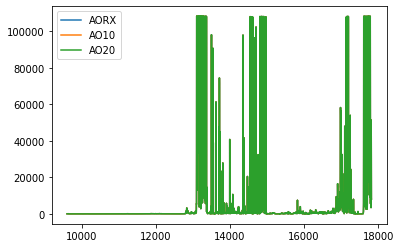

In [12]:
Resistive.plot()

<AxesSubplot:>

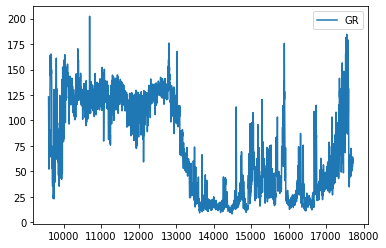

In [13]:
Gamma_Ray.plot()

<AxesSubplot:xlabel='TNPH', ylabel='DEPTH:1'>

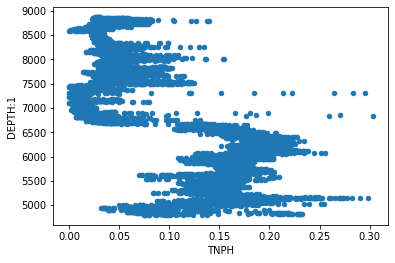

In [14]:
neutron_density = df[['DEPTH:1','TNPH','RHOZ']]
df.plot.scatter(x='TNPH',y='DEPTH:1',)

In [15]:
GR = df['GR']
IGR = (GR-GR_min)/(GR_max-GR_min)
Vsh = 1.7 - (3.38-(IGR+0.7)**2)**0.5
Vsh.head()
Vsh.shape



(18001,)

<AxesSubplot:xlabel='GR'>

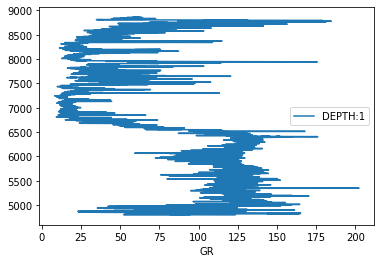

In [16]:
df.plot(x='GR',y='DEPTH:1')

<AxesSubplot:xlabel='NPHI'>

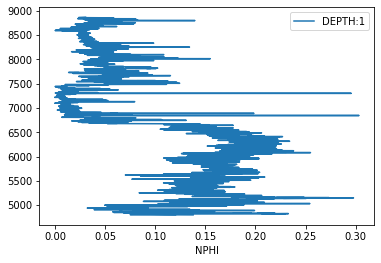

In [17]:
df.plot.line(x='NPHI',y='DEPTH:1')

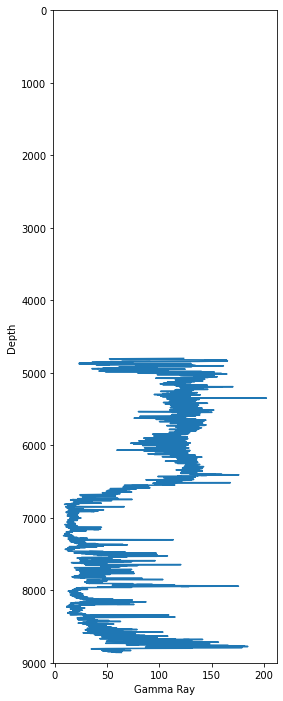

In [18]:
fig , axs = plt.subplots(figsize=(4,12))
plt.plot(df['GR'],df['DEPTH:1'])
plt.xlabel('Gamma Ray')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))
fig.savefig("Gammaray.png")


C:\Users\camil\Documents\Sinergia 2021\venv\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


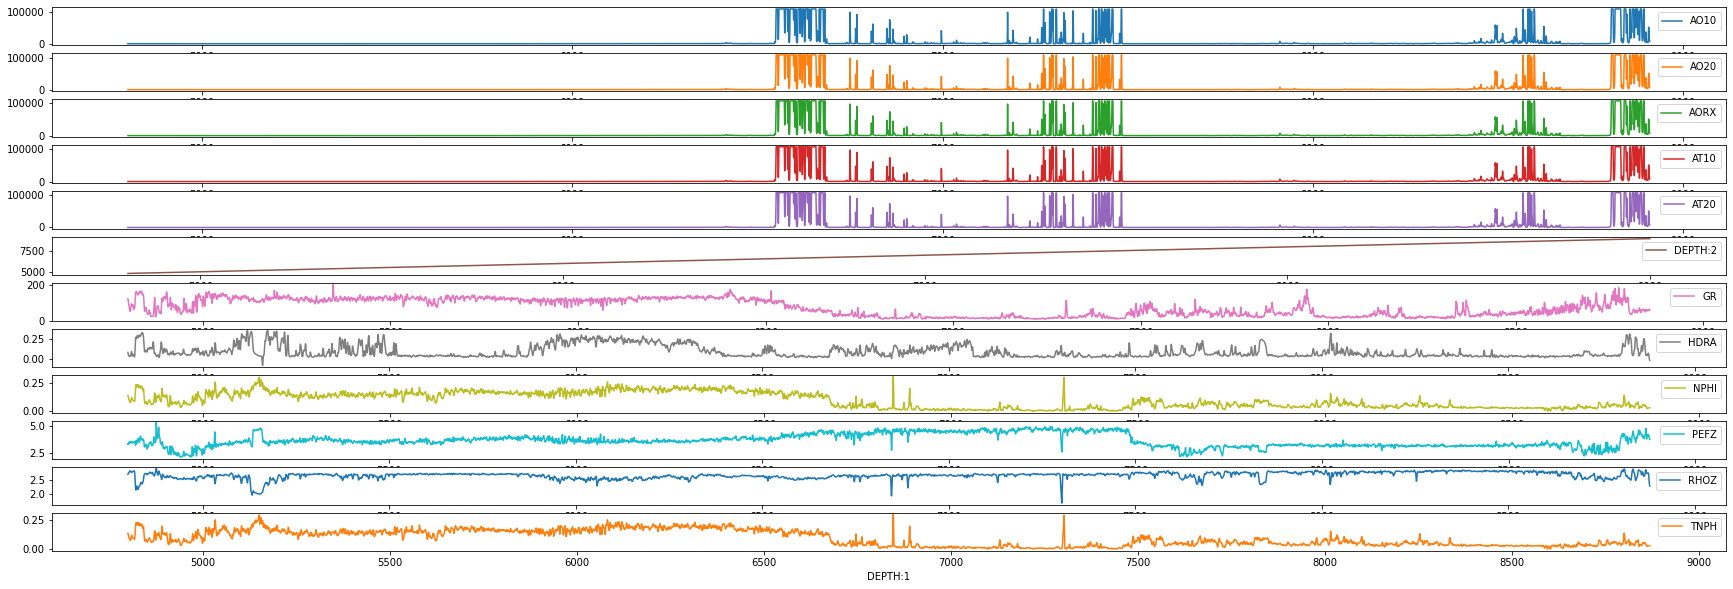

In [19]:
fig, axs = plt.subplots(figsize=(30,10))
df.plot(x='DEPTH:1',ax = axs,figsize=(30,10),subplots=True)
fig.savefig("Resumen de registros.png")

(9000.0, 0.0)

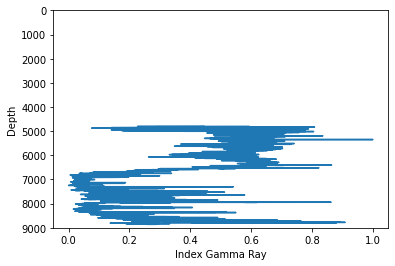

In [20]:
df['IGR'] = (df['GR']-GR_min)/(GR_max-GR_min)
df['Vshale'] = 1.7 - (3.38-(df['IGR']+0.7**2))**0.5
plt.plot(df['IGR'],df['DEPTH:1'])
plt.xlabel('Index Gamma Ray')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))

(9000.0, 0.0)

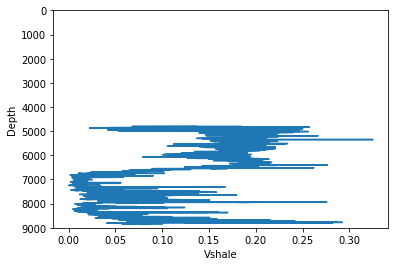

In [21]:
plt.plot(df['Vshale'],df['DEPTH:1'])
plt.xlabel('Vshale')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))

In [22]:
# df.to_excel("Registro_1.xlsx",sheet_name="Registro_1",index=False)
df

,DEPTH:1,AO10,AO20,AORX,AT10,AT20,DEPTH:2,GR,HDRA,NPHI,PEFZ,RHOZ,TNPH,IGR,Vshale
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,8998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,8998.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,8999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,8999.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
